# Building Recommender Systems for Movie Rating Prediction Using An Undercomplete Sparse Autoencoder [1]


## Introduction

### Self-supervised learning

In week 4 of this class, we studied matrix factorization and attempted to apply the technique to find a way to represent each user based on their movie ratings, a kind of user profile, by factorizing this ratings matrix using Non-negative Matrix Factorization, in order to predict how they would rate a movie they had not rated before.

This technique is part of a larger class of unsupervised learning techniques called self-supervised, whose purpose is to find a way to represent the data by learning to predict the data itself from a representation, itself learned from the data. In other words, we make up a representation distribution for the data, then generate another distribution from the representation distribution, we measure how close it is from the actual data, then modify the parameters of both made-up distributions in order to fit the data better. The representation distribution is called the latent distribution. 
Because the process involves generating made-up data resembling the actual data, it is called a generative model.

Generative Pre-Training, otherwise known as GPT utilizes this framework, applying it to sequences of text. It is made of an encoder and a decoder network. The purpose of the encoder network is to infer the values of the latent variables from the data and the purpose of the decoder network is to infer the values of the “made-up” data from the values of the latent variables.

### What is an autoencoder?

An autoencoder is a neural network made of two networks: an encoder network and a decoder network. Its purpose is to find a latent distribution from the data that can be used to generate another distribution as close to the data distribution as possible.

Neural networks can have lots of layers: then they are called deep. Or they can have just one hidden layer and are called shallow. 

In a typical feed forward network, the kind of network we are concerned with here, each layer is represented by a matrix of weights (W), a bias vector (b) and an activation function (f). The dimension of the bias vector is the dimension of the layer. The bias vector is actually also a vector of weights. We have seen it in regression: the weight value of the intercept. In this case the layer only had one dimension, so the bias vector was just a scalar. W has the dimensions: number of features of the previous layer by number of dimensions of the layer. The bias vector is a horizontal vector that is piled as many times as the dimension of the previous layer in order to compute a bias matrix.

During inference, each layer output is computed sequentially: given a previous layer output matrix $X_{l-1}$, the output $X_l$ of the layer is:

$$ X_l = f(X_{l-1}. W + matrix\_b)$$


Typically, the function f is applied individually to each matrix entry. It can be the identity function, which is the same as applying no function. The layer is then called “linear”. It can be 0 for any negative entry and the entry itself if positive. The latter function is called Rectified Linear otherwise known as ReLu: Rectified because like with electrical current, only the positive values are let through. Linear Units because when the value is positive the value of ReLu for the entry is no different than the value of the entry itself, like a linear layer: as if it was just multiplied by 1.

So one can build a shallow autoencoder having just one hidden layer, with two layers total for the network. If the dimension of the hidden layer is more than the dimension of the input layer (the features dimension), the autoencoder is called overcomplete, because the space of the hidden layer is defined by a basis of vectors whose dimension is larger than the basis defining the input space: an overcomplete basis. Conversely, if the dimension of the hidden layer is less than that of the input layer, it is called undercomplete.

### The autoencoder view of matrix factorization

One can think of matrix factorization as building a shallow undercomplete autoencoder with purely linear activation functions and without bias weights. Let us call $invH$ the weight matrix of the encoder layer, and $H$ the weight matrix of the decoder layer. The network is trained to perform the identity operation on the data, so approximately: $$ I \approx invH . H $$.

Matrix factorization consists of finding two matrices $W_{train}$ and $H$, such that the data: $X_{train}$ is or approximates the matrix product of $W_{train}$ and $H$:

$$X_{train} \approx X_{train\_approx} =W_{train}. H$$

So if we train the autoencoder on $X_{train}$, we get the equality:

$$X_{train\_approx} = X_{train} . invH . H$$.

With $X_{train\_approx}$ the approximate reconstruction of $X_{train}$: the predictions of $X_{train}$. This is another way to say that: $W_{train} = X_{train} . invH$

In matrix factorization, we get a transform $W_{test}$, which is then multiplied by the matrix $H$ yielding an approximation of the test data $X_{test}$.

$$X_{test\_approx} = X_{test} . invH . H = W_{test} . H$$

The purpose of getting an approximation is that it is more general than $X_{test}$ itself and can therefore be used to generate missing data.

To summarize what happens under the hood in matrix factorization:
First, find a matrix $H$ and its approximate left inverse $invH$: the fit function. $H$ is called the components matrix.
Second, use them to generate a transform of the test data: $W_{test} = X_{test} . invH$: the transform function.
Third, generate approximate data $X_{test\_approx}$: by computing $W_{test} . H$.

### Autoencoders as an extension of matrix factorization to find a latent distribution of the data

In the previous paragraph, we showed that factorizing the data matrix is equivalent to building an undercomplete shallow autoencoder without bias weights, then using the results to generate missing values.

However, autoencoders do not have to be shallow, may have biases and do not have to be made with linear layers. They actually perform better as generative models (see ChatGPT) if they are not. And if they may even be overcomplete, provided certain conditions are met: their hidden layers may have more dimensions than the input layer. The purpose of making them undercomplete is to avoid trivial solutions such as having weight matrices equal to the identity matrix and biases equal to zero, but trivial solutions may be avoided in many ways.

One such way is to use ReLu activation functions: it transforms about half of the outputs of a linear layer into zeros, effectively decreasing the dimension of the hidden layer by half. It makes the output of the layer sparse: having lots of zeros.

In any case, the reason for using non linear activation functions is because it makes for better representations. One could show that linear networks cannot compute the exclusive OR but non linear ones can. Generally, non-linear networks offer the possibility to find richer representations. 

## 1. Exploratory Data Analysis.

In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
users_ids_plus = pd.read_csv('data/users.csv')
movies_attributes = pd.read_csv('data/movies.csv')
X_y_train = pd.read_csv('data/train.csv')
X_y_test = pd.read_csv('data/test.csv')

In [3]:
users_ids_plus.head()

,uID,gender,age,accupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [4]:
n_users=len(users_ids_plus)
user_id2idx = dict([(users_ids_plus.uID[idx],idx) for idx in range(n_users)])

In [5]:
del users_ids_plus
movies_attributes.head()

,mID,title,year,Doc,Com,Hor,Adv,Wes,Dra,Ani,...,Chi,Cri,Thr,Sci,Mys,Rom,Fil,Fan,Act,Mus
0,1,Toy Story,1995,0,1,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,3,Grumpier Old Men,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Father of the Bride Part II,1995,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
n_movies=len(movies_attributes)
movie_id2idx = dict([(movies_attributes.mID[idx],idx) for idx in range(n_movies)])

In [7]:
X_y=pd.concat([X_y_train,X_y_test],ignore_index=True,axis=0)
X_y.head()

,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
4,2507,3074,5


In [8]:
X_y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
uID       1000209 non-null int64
mID       1000209 non-null int64
rating    1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB


For this work, I used the data provided in homework 3, of the present course from Pr. Geena Kim DTSA 5510, “Unsupervised Learning Algorithms”. These data consist of four .csv files containing respectively a table of user demographic data including user  IDs, a table of movie attributes including movie IDs, a training and a test table of users movie ratings. I only used the user demographics file to extract a Python dictionary assigning the Pandas DataFrame row index to the user ID for this row, for every row. I did the same thing with the file about movie attributes, only with movie IDs. For the last two files, I concatenated the sets labeled for training and testing to obtain a single DataFrame of about a million or movie ratings, organized in four columns: rating index, user ID, movie ID, rating.

The first order of priority was to verify there were no invalid ratings: either not a number or out of the zero to five range. If so replace them with 3s.

### Data cleaning

In [9]:
n_invalid_counts=0
for idx in range(len(X_y)):
    if np.isnan(X_y.rating[idx]):
        X_y.rating[idx]=3
        n_invalid_count+=1
    else:
        if X_y.rating[idx]<0 or X_y.rating[idx]>5:
            X_y.rating[idx]=3
            n_invalid_counts+=1
print('There were '+str(n_invalid_counts)+' invalid ratings')      

There were 0 invalid ratings


Not a surprise, the course authors had done the job already. The next step was to get an idea of the range of ratings counts, e. g. how many movies a given user rates. It may be harder to reliably predict unrated movies for users not having enough ratings.

### Data exploration 

In [10]:
rating_counts=np.zeros([len(user_id2idx)],np.int32)
for idx in range(len(X_y)):
    if X_y.rating[idx]>0:
        rating_counts[user_id2idx[X_y.uID[idx]]]+=1

<BarContainer object of 13 artists>

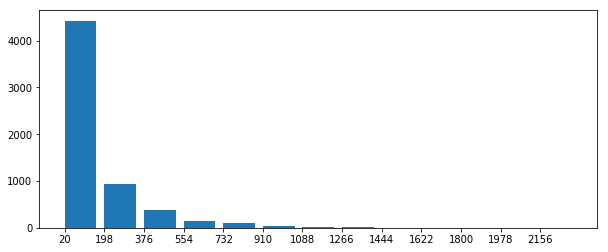

In [11]:
n_bins=13
bin_width=max(rating_counts)//n_bins
label_list=[str(min(rating_counts)+idx*bin_width) for idx in range(n_bins)]
hist=np.histogram(rating_counts,bins=n_bins)
range_values=max(rating_counts)-min(rating_counts)
fig,ax=plt.subplots(1,1,figsize=(10,4))
plt.bar(np.arange(n_bins),height=hist[0],align='edge',tick_label=label_list)

In [12]:
print('Number of movies rated by user who rated the fewest movies: '+str(min(rating_counts)))
print('Number of movies rated by user who rated the most movies: '+str(max(rating_counts)))

Number of movies rated by user who rated the fewest movies: 20
Number of movies rated by user who rated the most movies: 2314


Range: the user who rated the fewest movies only rated 20 movies, and the one who rated the most, rated over 2000: what a binge! By far, most users only rated between 20 to 198 movies. Having 20 movies at a minimum is reassuring.

### Dividing the data into training and test sets

The data was already randomized, so I simply divided it into two sets: 90 % for training and 10 % for testing.

In [13]:
train_test_split=9*len(X_y)//10
X_y_train=X_y.iloc[:train_test_split,:]
X_y_test=X_y.iloc[train_test_split:,:]
X_y_test=X_y_test.set_index(np.arange(len(X_y_test)))

In [14]:
X_y_train.head()

,uID,mID,rating
0,744,1210,5
1,3040,1584,4
2,1451,1293,5
3,5455,3176,2
4,2507,3074,5


In [15]:
X_y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900188 entries, 0 to 900187
Data columns (total 3 columns):
uID       900188 non-null int64
mID       900188 non-null int64
rating    900188 non-null int64
dtypes: int64(3)
memory usage: 20.6 MB


In [16]:
users_ratings=np.zeros([n_users,n_movies],np.int32)
n_training_samples=len(X_y_train)
for idx in range(n_training_samples):
    users_ratings[user_id2idx[X_y_train.uID[idx]],movie_id2idx[X_y_train.mID[idx]]]=X_y_train.rating[idx]

In [17]:
del X_y_train
X_y_test.head()

,uID,mID,rating
0,881,1918,2
1,4852,2804,5
2,5831,3360,4
3,5077,448,3
4,3118,1224,4


In [18]:
X_y_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100021 entries, 0 to 100020
Data columns (total 3 columns):
uID       100021 non-null int64
mID       100021 non-null int64
rating    100021 non-null int64
dtypes: int64(3)
memory usage: 3.1 MB


## 2. Building Models

### Matrix Factorization

#### 2.1. Factorizing the ratings matrix replacing zeros with 3s with TruncatedSVD

In homework 4, we attempted to use non negative matrix factorization of the user ratings matrix directly and got a root mean squared value of 2.68

The root mean square error measures the average distance in units of rating between the predicted and actual values, so 2.68 is very large. The problem came from the ratings matrix coding as zero non rated movies, which is equivalent to one unit below the  worst than a rating of 1. It is the same as assuming non rated movies as worse than the worst when predicting the rating of a movie. A slightly better assumption is to assume that non rated movies have a value of 3. This is implemented in the following code.

This time though, because replacing all zeros by 3s makes the matrix zeros disappear, we can use Singular Value Decomposition.

In [20]:
n_genres=18

In [94]:
measurements=np.zeros([2,6])

In [19]:
def root_mean_square_error(y_pred,test_data):
        y_true=np.array(test_data.rating)
        return np.mean(np.sqrt((y_pred-y_true)**2))


In [96]:
def predict_from_matrix_v1(test_data, n_latents, ratings,uid2idx,mid2idx):
        n_samples = len(test_data)
        n_users,n_movies=ratings.shape
        ratings_with_3s = np.where(ratings==0.0,3.0*np.ones([n_users,n_movies]),np.float32(ratings))
        tsvd=TruncatedSVD(n_components=n_latents)
        tsvd.fit(ratings_with_3s)
        preds = np.zeros([n_samples])
        for test_idx in range(n_samples):
            user_rating_vector = np.reshape(ratings[uid2idx[test_data.uID[test_idx]]],[1,-1])
            user_rating_with_3s = np.where(user_rating_vector==0.0,3*np.ones([1,n_movies]),np.float32(user_rating_vector))
            rating_transform=tsvd.transform(user_rating_with_3s)
            movie_idx=mid2idx[test_data.mID[test_idx]]
            preds[test_idx]=np.matmul(rating_transform,np.reshape(tsvd.components_[:,movie_idx],[-1,1]))
        return preds

In [97]:
print("RMSE for label predictions based on SVD factorization with zeros replaced by 3s")
preds_SVD=predict_from_matrix_v1(X_y_test, n_genres,users_ratings,user_id2idx,movie_id2idx)
measurements[0,0]=root_mean_square_error(preds_SVD,X_y_test)
print(measurements[0,0])

RMSE for label predictions based on SVD factorization with zeros replaced by 3s
0.8530082529115297


In [98]:
print("Label prediction accuracy:")
preds_SVD_int=np.int32(preds_SVD+0.5)
measurements[1,0]=np.mean(np.float32(np.equal(preds_SVD_int,X_y_test.rating)))
print(measurements[1,0])

Label prediction accuracy:
0.3191030025482178


We get a better error than similarity based methods. This is not a surprise: by replacing zeros by 3s in the Movie Ratings matrix, we make the assumption that unrated movies are equivalent to movies rated average. This is an assumption though that is not really correct, but at least it does not consider zeros as ratings less than ones. Looking by the accuracy on the predicting the labels, there is room to go up.

#### 2.2. Factorizing the ratings matrix replacing zeros with 3s with keras using an autoencoder architecture

Let us try to do exactly the same thing using keras first. Then talk about undercomplete sparse autoencoders.

In [21]:
n_latents=n_genres
ratings_with_3s = np.where(users_ratings==0.0,3.0*np.ones([n_users,n_movies]),np.float32(users_ratings))

In [102]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(n_latents, use_bias=False),
                                    tf.keras.layers.Dense(n_movies, use_bias=False)])
model.compile(optimizer = 'adam', loss = 'mse')
history=model.fit(ratings_with_3s, ratings_with_3s, batch_size=100, epochs=5,validation_split=0.2,shuffle=True)
model.summary()

Train on 4832 samples, validate on 1208 samples
Epoch 1/5
4832/4832 [==============================] - 1s 187us/step - loss: 2.0186 - val_loss: 0.0714
Epoch 2/5
4832/4832 [==============================] - 0s 103us/step - loss: 0.0611 - val_loss: 0.0682
Epoch 3/5
4832/4832 [==============================] - 0s 100us/step - loss: 0.0616 - val_loss: 0.0567
Epoch 4/5
4832/4832 [==============================] - 0s 100us/step - loss: 0.0663 - val_loss: 0.0631
Epoch 5/5
4832/4832 [==============================] - 0s 103us/step - loss: 0.0586 - val_loss: 0.0575
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 18)                69894     
_________________________________________________________________
dense_6 (Dense)              (None, 3883)              69894     
Total params: 139,788
Trainable params: 139,788
Non-trainable params: 0
___________________________________

This network decomposes the ratings matrix X into a matrix W and a matrix H, with W equal to X.invH. 

Note: in order for this to work, the correct name for the layer needs to be used: it should be 'dense_1' for the invH matrix, and 'dense_2' for H, but if the model cell is ran again, a new instance of the model changes the layer names. Please adjust the names as indicated in the model summary.

In [103]:
[invH]=model.get_layer('dense_1').get_weights()
[H]=model.get_layer('dense_2').get_weights()
print(invH.shape)
print(H.shape)

(3883, 18)
(18, 3883)


In [104]:
def predict_from_matrix_v2(ratings_with_3s,test_data, invH, H,uid2idx,mid2idx):
        n_samples = len(test_data)
        preds = np.zeros([n_samples])
        for test_idx in range(n_samples):
            transform= np.matmul(np.reshape(ratings_with_3s[uid2idx[test_data.uID[test_idx]]],[1,-1]),invH)
            preds[test_idx]=np.sum(transform*H[:,mid2idx[test_data.mID[test_idx]]])
        return preds

In [105]:
print("RMSE for label predictions based on matrix factorization with zeros replaced by 3s")
preds_keras_model2=predict_from_matrix_v2(ratings_with_3s,X_y_test,invH,H,user_id2idx,movie_id2idx)
measurements[0,1]=root_mean_square_error(preds_keras_model2,X_y_test)
print(measurements[0,1])

RMSE for label predictions based on matrix factorization with zeros replaced by 3s
0.9706889002204555


In [106]:
print("Label prediction accuracy:")
preds_keras_model2_int=np.int32(preds_keras_model2+0.5)
measurements[1,1]=np.mean(np.float32(np.equal(preds_keras_model2_int,X_y_test.rating)))
print(measurements[1,1])

Label prediction accuracy:
0.2659541368484497


Not as good as with Singular Value Decomposition probably because my algorithm to obtain invH and H is likely not as precise.

#### 2.3. Factorizing the ratings matrix masking zero ratings with keras using an autoencoder architecture

When computing the mse, we predict 3 for missing values. A better strategy is to predict zero error with a missing value, whatever the prediction is when training the network. This is done by changing the loss in the keras model computed by the mean over each individual prediction loss term: $(y\_pred(i) - y\_true(i))^2$ multiplied by zero when the prediction is missing: $$ masked\_MSE=\Sigma _{i=0}^{n\_movies-1} ((y\_pred(i) - y\_true(i))^2)sign\_of(y\_true)$$

Nonetheless, we have seen when factorizing the ratings matrix directly, we cannot use it as an input to the network, because then zeros are interpreted by the network as worse scores than 1.

In [22]:
def maskedMSE(y_true, y_pred):
    return tf.reduce_mean(tf.sign(y_true)*(y_true-y_pred)**2)

In [109]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(n_latents, use_bias=False),
                                    tf.keras.layers.Dense(n_movies, use_bias=False)])
model.compile(optimizer = 'adam', loss = maskedMSE)
history=model.fit(ratings_with_3s, users_ratings, batch_size=100, epochs=8,validation_split=0.2,shuffle=True)
model.summary()

Train on 4832 samples, validate on 1208 samples
Epoch 1/8
4832/4832 [==============================] - 1s 176us/step - loss: 0.1364 - val_loss: 0.0395
Epoch 2/8
4832/4832 [==============================] - 0s 87us/step - loss: 0.0375 - val_loss: 0.0374
Epoch 3/8
4832/4832 [==============================] - 0s 86us/step - loss: 0.0365 - val_loss: 0.0354
Epoch 4/8
4832/4832 [==============================] - 0s 83us/step - loss: 0.0362 - val_loss: 0.0349
Epoch 5/8
4832/4832 [==============================] - 0s 86us/step - loss: 0.0358 - val_loss: 0.0350
Epoch 6/8
4832/4832 [==============================] - 0s 86us/step - loss: 0.0371 - val_loss: 0.0370
Epoch 7/8
4832/4832 [==============================] - 0s 86us/step - loss: 0.0361 - val_loss: 0.0432
Epoch 8/8
4832/4832 [==============================] - 0s 86us/step - loss: 0.0371 - val_loss: 0.0359
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
den

Note: in order for this to work, the correct name for the layer needs to be used: it should be 'dense_3' for the invH matrix, and 'dense_4' for H, but if the model cell is ran again, a new instance of the model changes the layer names. Please adjust the names as indicated in the model summary.

In [110]:
[invH]=model.get_layer('dense_3').get_weights()
[H]=model.get_layer('dense_4').get_weights()

In [111]:
print("RMSE for label predictions based on matrix factorization with zeros replaced by 3s")
preds_keras_model3=predict_from_matrix_v2(ratings_with_3s,X_y_test,invH,H,user_id2idx,movie_id2idx)
measurements[0,2]=root_mean_square_error(preds_keras_model3,X_y_test)
print(measurements[0,2])

RMSE for label predictions based on matrix factorization with zeros replaced by 3s
0.7875336282557377


In [112]:
print("Label prediction accuracy:")
preds_keras_model3_int=np.int32(preds_keras_model3+0.5)
measurements[1,2]=np.mean(np.float32(np.equal(preds_keras_model3_int,X_y_test.rating)))
print(measurements[1,2])

Label prediction accuracy:
0.3732116222381592


Not bad. Better than SVD !

Overall matrix factorization does not work that bad for movie rating prediction, but is still on average close to 1 rating point from the target and accuracy is at best around 40 %. This is likely due to the latent variables being non linear functions of user rating patterns, and matrix factorization only considers linear functions. We also chose the number of components to equal the number of genres. What about gender and age? Women and men, children and adult often do not like the same movies. So the number of components could have been set to 18 genres + 2. Choosing the number of components introduces another assumption about the number of latent variables. Finally, all these models are equivalent to shallow autoencoders.

An alternative would be a neural network with one (or more) intermediate layers with many more units than 18 or 20, incorporating non linear activation functions and using deeper networks. 

### Autoencoder with non linear units to encode latent variables

#### 2.4. Shallow autoencoder

In [113]:
n_latents=18
model = tf.keras.models.Sequential([tf.keras.layers.Dense(n_latents,activation='relu'),
                                    tf.keras.layers.Dense(n_movies)])
model.compile(optimizer = 'adam',loss = maskedMSE)

In [114]:
history=model.fit(ratings_with_3s, users_ratings, batch_size=100, epochs=10,validation_split=0.2,shuffle=True)
model.summary()

Train on 4832 samples, validate on 1208 samples
Epoch 1/10
4832/4832 [==============================] - 1s 198us/step - loss: 0.2175 - val_loss: 0.0427
Epoch 2/10
4832/4832 [==============================] - 0s 90us/step - loss: 0.0386 - val_loss: 0.0369
Epoch 3/10
4832/4832 [==============================] - 0s 89us/step - loss: 0.0364 - val_loss: 0.0354
Epoch 4/10
4832/4832 [==============================] - 0s 87us/step - loss: 0.0358 - val_loss: 0.0355
Epoch 5/10
4832/4832 [==============================] - 0s 90us/step - loss: 0.0357 - val_loss: 0.0349
Epoch 6/10
4832/4832 [==============================] - 0s 93us/step - loss: 0.0357 - val_loss: 0.0350
Epoch 7/10
4832/4832 [==============================] - 0s 90us/step - loss: 0.0354 - val_loss: 0.0349
Epoch 8/10
4832/4832 [==============================] - 0s 90us/step - loss: 0.0353 - val_loss: 0.0347
Epoch 9/10
4832/4832 [==============================] - 0s 90us/step - loss: 0.0351 - val_loss: 0.0346
Epoch 10/10
4832/4832 [=

Note: in order for this to work, the correct name for the layer needs to be used: it should be 'dense_5' for the invH matrix, and 'dense_6' for H, but if the model cell is ran again, a new instance of the model changes the layer names. Please adjust the names as indicated in the model summary.

In [115]:
[W1,b1]=model.get_layer('dense_5').get_weights()
[W2,b2]=model.get_layer('dense_6').get_weights()

In [116]:
def predict_from_autoencoder(ratings,test_data, W1,b1,W2,b2,uid2idx,mid2idx):
        n_samples = len(test_data)
        preds = np.zeros([n_samples])
        for test_idx in range(n_samples):
            transform= np.matmul(np.reshape(ratings[uid2idx[test_data.uID[test_idx]]],[1,-1]),W1)
            latent=np.maximum(0.0,np.reshape(transform,[-1])+b1)
            movie_idx=mid2idx[test_data.mID[test_idx]]
            preds[test_idx]=np.sum(latent*W2[:,movie_idx])+b2[movie_idx]
        return preds

In [117]:
print("RMSE for label predictions based on sparse undercomplete autoencoder with centered inputs")
preds_keras_model4=predict_from_autoencoder(ratings_with_3s,X_y_test,W1,b1,W2,b2,user_id2idx,movie_id2idx)
measurements[0,3]=root_mean_square_error(preds_keras_model4,X_y_test)
print(measurements[0,3])

RMSE for label predictions based on sparse undercomplete autoencoder with centered inputs
0.7606882552580159


In [118]:
print("Label prediction accuracy:")
preds_keras_model4_int=np.int32(preds_keras_model4+0.5)
measurements[1,3]=np.mean(np.float32(np.equal(preds_keras_model4_int,X_y_test.rating)))
print(measurements[1,3])

Label prediction accuracy:
0.4058047831058502


Not bad either, better than the previous one.

But maybe we can get better. The number of latents is rather small: 18. Using Rectified linear units, only about half these units have an output above zero, which makes the problem even worse. Let’s try to increase the number of latent variables.

However, the predict_from_autoencoder() function takes a long time to complete.

As with more components, the matrices W1 and W2 become very large, which markedly increases computation time. Fortunately, there is a work around: using parallel computing with keras running on the GPU.

The beauty of parallel computing, and the reason why the NVDIA stock got so high (disclaimer: I do not own any such stocks), is because the multiplication of a matrix m by n with a matrix n by p is the computation of $n^2$ inner products, which can be done at the same time by $n^2$ processors. Each inner product also requires n products, so if we have $n^3$ processors available, we can do these operations in one flop. Then we have to sum n of these products, which can be done in $\log n$ time. In our calse $n = n\_latents$ and there are 300,000 such matrix multiplications to do: one per sample. So, by increasing $n\_latents$ form 18 to 150, we go from $18^3\log 18=16857$ to $150^3\log 150=16910894$ computations. This becomes too long to do sequentially. With a GPU, it does not matter if we have $18^3=5832$ or $150^3=3375000$ threads computing: it takes $\log(150/18)$, less than twice the time.

So we will build a keras model for the prediction function, thus harnessing the power of parallel computing.

First, the following function which converts the X_y_test dataframe into a numpy array of users and movies indexed by indices rather than IDs.

In [23]:
def convert_df(df,uid2idx,mid2idx):
    n_samples=len(df)
    conversion=np.zeros([n_samples,3],np.int32)
    for idx in range(n_samples):
        conversion[idx,0]=uid2idx[df.uID[idx]]
        conversion[idx,1]=mid2idx[df.mID[idx]]
        conversion[idx,2]=df.rating[idx]
    return conversion
test_np = convert_df(X_y_test,user_id2idx,movie_id2idx)

In [24]:
class GetRating(tf.keras.layers.Layer):
    def __init__(self,ratings):
        super().__init__()
        self.ratings=ratings
        self.n_units=ratings.shape[0]
        self.mask_base=tf.reshape(tf.constant(np.float32(np.arange(self.n_units))),[1,self.n_units])
        
    def call(self,inputs):
        one_hot=tf.cast(tf.equal(tf.tile(inputs,[1,self.n_units]),self.mask_base),tf.float32)
        return tf.matmul(one_hot,tf.cast(self.ratings,tf.float32))

In [121]:
class SelectMovie(tf.keras.layers.Layer):
    def __init__(self,W2,b2):
        super().__init__()
        self.W2=W2
        self.b2=b2
        self.n_units=W2.shape[1]
        self.mask_base=tf.reshape(tf.constant(np.float32(np.arange(self.n_units))),[1,self.n_units])
        
    def call(self,inputs):
        latent,movie_idx=inputs
        all_preds=tf.matmul(latent,W2)+b2
        one_hot=tf.cast(tf.equal(tf.tile(movie_idx,[1,self.n_units]),self.mask_base),tf.float32)
        return tf.reduce_sum(all_preds*one_hot,axis=1)

In [122]:
input1=tf.keras.Input(shape=(1,))
input2=tf.keras.Input(shape=(1,))
x1=GetRating(ratings_with_3s)(input1)
x2=tf.keras.layers.Dense(n_latents,activation='relu',weights=[W1,b1],trainable=False)(x1)
outputs=SelectMovie(W2,b2)([x2,input2])

predictor=tf.keras.Model(inputs=[input1,input2],outputs=outputs)

In [123]:
predictor.compile(optimizer='adam',loss = 'categorical_crossentropy')

In [124]:
predictions=predictor.predict([test_np[:,0],test_np[:,1]])

In [125]:
print("RMSE for label predictions based on sparse undercomplete autoencoder")
print(root_mean_square_error(predictions,X_y_test))
print("Same with previous method")
print(measurements[0,3])

RMSE for label predictions based on sparse undercomplete autoencoder
0.7606882705811212
Same with previous method
0.7606882552580159


In [126]:
print("Label prediction accuracy:")
predictions_int=np.int32(predictions+0.5)
print(np.mean(np.float32(np.equal(predictions_int,X_y_test.rating))))
print("Same with previous method")
print(measurements[1,3])

Label prediction accuracy:
0.40580478
Same with previous method
0.4058047831058502


So for the last two models, we will use keras to get the predictions too.

First, let's simply change the number of latent variables

In [127]:
n_latents=150
model = tf.keras.models.Sequential([tf.keras.layers.Dense(n_latents,activation='relu'),
                                    tf.keras.layers.Dense(n_movies)])
model.compile(optimizer = 'adam', loss = maskedMSE)

In [128]:
history=model.fit(ratings_with_3s, users_ratings, batch_size=100, epochs=10,validation_split=0.2,shuffle=True)
model.summary()

Train on 4832 samples, validate on 1208 samples
Epoch 1/10
4832/4832 [==============================] - 2s 322us/step - loss: 0.1075 - val_loss: 0.0365
Epoch 2/10
4832/4832 [==============================] - 0s 103us/step - loss: 0.0395 - val_loss: 0.0410
Epoch 3/10
4832/4832 [==============================] - 0s 100us/step - loss: 0.0373 - val_loss: 0.0372
Epoch 4/10
4832/4832 [==============================] - 0s 100us/step - loss: 0.0362 - val_loss: 0.0354
Epoch 5/10
4832/4832 [==============================] - 0s 103us/step - loss: 0.0363 - val_loss: 0.0350
Epoch 6/10
4832/4832 [==============================] - 0s 101us/step - loss: 0.0359 - val_loss: 0.0349
Epoch 7/10
4832/4832 [==============================] - 0s 103us/step - loss: 0.0360 - val_loss: 0.0351
Epoch 8/10
4832/4832 [==============================] - 0s 101us/step - loss: 0.0366 - val_loss: 0.0439
Epoch 9/10
4832/4832 [==============================] - 0s 100us/step - loss: 0.0360 - val_loss: 0.0348
Epoch 10/10
4832

In [129]:
[W1,b1]=model.get_layer('dense_7').get_weights()
[W2,b2]=model.get_layer('dense_8').get_weights()

In [130]:
input1=tf.keras.Input(shape=(1,))
input2=tf.keras.Input(shape=(1,))
x1=GetRating(ratings_with_3s)(input1)
x2=tf.keras.layers.Dense(n_latents,activation='relu',weights=[W1,b1],trainable=False)(x1)
outputs=SelectMovie(W2,b2)([x2,input2])

predictor=tf.keras.Model(inputs=[input1,input2],outputs=outputs)

In [131]:
# There are no trainable parameters so this actually does not matter but we still have to compile the model
predictor.compile(optimizer='adam',loss = 'categorical_crossentropy')

In [132]:
predictions=predictor.predict([test_np[:,0],test_np[:,1]])

In [133]:
print("RMSE for label predictions based on sparse undercomplete autoencoder")
measurements[0,4]=root_mean_square_error(predictions,X_y_test)
print(measurements[0,4])

RMSE for label predictions based on sparse undercomplete autoencoder
0.7602566000233147


In [134]:
print("Label prediction accuracy:")
predictions_int=np.int32(predictions+0.5)
measurements[1,4]=np.mean(np.float32(np.equal(predictions_int,X_y_test.rating)))
print(measurements[1,4])

Label prediction accuracy:
0.39364734292030334


Not bad either, about the same. So it was not so much the size of the latent layer.

Maybe be it is the depth of the network.

#### 2.5 Deeper autoencoder

In [135]:
n_hidden_e=80
n_latents=20
n_hidden_d=80
model = tf.keras.models.Sequential([tf.keras.layers.Dense(n_hidden_e,activation='relu'),
                                    tf.keras.layers.Dense(n_latents,activation='relu'),
                                    tf.keras.layers.Dense(n_hidden_d,activation='relu'),
                                    tf.keras.layers.Dense(n_movies)])
model.compile(optimizer = 'adam', loss = maskedMSE)

In [136]:
history=model.fit(ratings_with_3s, users_ratings, batch_size=100, epochs=10,validation_split=0.2,shuffle=True)
model.summary()

Train on 4832 samples, validate on 1208 samples
Epoch 1/10
4832/4832 [==============================] - 2s 462us/step - loss: 0.1031 - val_loss: 0.0367
Epoch 2/10
4832/4832 [==============================] - 0s 101us/step - loss: 0.0373 - val_loss: 0.0356
Epoch 3/10
4832/4832 [==============================] - 0s 101us/step - loss: 0.0367 - val_loss: 0.0353
Epoch 4/10
4832/4832 [==============================] - 0s 100us/step - loss: 0.0369 - val_loss: 0.0352
Epoch 5/10
4832/4832 [==============================] - 0s 100us/step - loss: 0.0360 - val_loss: 0.0351
Epoch 6/10
4832/4832 [==============================] - 0s 100us/step - loss: 0.0358 - val_loss: 0.0349
Epoch 7/10
4832/4832 [==============================] - 0s 103us/step - loss: 0.0359 - val_loss: 0.0348
Epoch 8/10
4832/4832 [==============================] - 1s 105us/step - loss: 0.0358 - val_loss: 0.0348
Epoch 9/10
4832/4832 [==============================] - 0s 99us/step - loss: 0.0357 - val_loss: 0.0355
Epoch 10/10
4832/

In [137]:
[W1,b1]=model.get_layer('dense_11').get_weights()
[W2,b2]=model.get_layer('dense_12').get_weights()
[W3,b3]=model.get_layer('dense_13').get_weights()
[W4,b4]=model.get_layer('dense_14').get_weights()

In [138]:
class SelectMovieDeep(tf.keras.layers.Layer):
    def __init__(self,W4,b4):
        super().__init__()
        self.W4=W4
        self.b4=b4
        self.n_units=W4.shape[1]
        self.mask_base=tf.reshape(tf.constant(np.float32(np.arange(self.n_units))),[1,self.n_units])
        
    def call(self,inputs):
        latent,movie_idx=inputs
        all_preds=tf.matmul(latent,W4)+b4
        one_hot=tf.cast(tf.equal(tf.tile(movie_idx,[1,self.n_units]),self.mask_base),tf.float32)
        return tf.reduce_sum(all_preds*one_hot,axis=1)

In [139]:
input1=tf.keras.Input(shape=(1,))
input2=tf.keras.Input(shape=(1,))
x1=GetRating(ratings_with_3s)(input1)
x2=tf.keras.layers.Dense(n_hidden_e,activation='relu',weights=[W1,b1],trainable=False)(x1)
x3=tf.keras.layers.Dense(n_latents,activation='relu',weights=[W2,b2],trainable=False)(x2)
x4=tf.keras.layers.Dense(n_hidden_d,activation='relu',weights=[W3,b3],trainable=False)(x3)
outputs=SelectMovieDeep(W4,b4)([x4,input2])

predictor_deep=tf.keras.Model(inputs=[input1,input2],outputs=outputs)

In [140]:
# There are no trainable parameters so this actually does not matter but we still have to compile the model
predictor_deep.compile(optimizer='adam',loss = 'categorical_crossentropy')

In [141]:
predictions_deep=predictor_deep.predict([test_np[:,0],test_np[:,1]])

In [142]:
print("RMSE for label predictions based on sparse undercomplete deeper autoencoder")
measurements[0,5]=root_mean_square_error(predictions_deep,X_y_test)
print(measurements[0,5])

RMSE for label predictions based on sparse undercomplete deeper autoencoder
0.7651896632900824


In [146]:
print("Label prediction accuracy:")
predictions_deep_int=np.int32(predictions_deep+0.5)
measurements[1,5]=np.mean(np.float32(np.equal(predictions_deep_int,X_y_test.rating)))
print(measurements[1,5])

Label prediction accuracy:
0.38740864396095276


About the same. So depth does not have an impact either.

I used early stopping as a regularization technique, training up until the validation accuracy got as close as possible to the training accuracy, attempted using regularizers such as the L1 and L2 norm, but did not get better results. So it seams like the model still overfits. It was worse with a 70/30% data split. This is why I chose a more usual ratio is 10:1, thus providing more training data, and ran the experiments again. 

For now, let us summarize the results.

## 3. Results

In [147]:
columns=['Matrix Factorization: SVD','Keras','Keras Masked MSE','Shallow AE 18 latents','Shallow 150','Deeper AE']
results=pd.DataFrame(measurements,index=['RMSE','Accuracy'],columns=columns)

In [148]:
results.head()

,Matrix Factorization: SVD,Keras,Keras Masked MSE,Shallow AE 18 latents,Shallow 150,Deeper AE
RMSE,0.853008,0.970689,0.787534,0.760688,0.760257,0.765190
Accuracy,0.319103,0.265954,0.373212,0.405805,0.393647,0.387409


Looking at this table makes it clear that replacing zero ratings by the average 3 improved the root mean squared error for all the models. Simply replicating the factorization with keras yielded worse number, most likely because the algorithm used with keras gave worse approximations for the transform and the components. 

On the other hand, training the network masking unrated movies (e. g. assigning a zero loss in the training algorithm for movies the user had not rated), improved the Root Mean Square error of all models including the keras matrix factorization one.

The best performance was obtained by the undercomplete sparse autoencoders although it did not matter if they were shallow or deeper, or if the number of latents was large or small. The models improved accuracy compared to SVD by 3 points. 


## Conclusion

This work explored using a sparse undercomplete autoencoder to find a latent distribution to fit the data and compared it to using matrix factorization. The main results was that a sparse autoencoder performed better than matrix factorization as long as zero ratings, standing for user unrated movies, were replaced by the average rating, and that the training loss assigned zero loss for movies not rated by the sample user and there was enough training data.

Other factors such as the dimension of the latent vector or the depth of the network did not have much influence, probably because it makes the models overfit. Early stopping was used as a regularizer. I also attempted to use L1 and L2 penalties (not shown), but it did not help. Using the user demographic data as a covariate may also have affected the quality of the prediction. This could be done with a conditional autoencoder architecture.

This assignment is about unsupervised learning, so we did not explore an obvious solution of using supervised learning: building a categorical classifier with the five ratings as the five possible categories. It may turn out to be a better strategy to predict labels. 

Nonetheless, this work also demonstrated the advantage of parallel processing. Using sparse matrices would have been possible with the user ratings and latent representations, but the weights matrices had to be dense, thus canceling the advantage of such sparse matrices when performing matrix multiplications. 

Parallel processing was really a plus in this work. Using a laptop and a Keras backend software taking advantage of GPU computing made scaling the autoencoder models up easy without a corresponding cost in execution time. Manipulating large, dense matrices, like the ratings matrix is not a big obstacle when using parallel computing. Memory is more of an issue. Still 8 GB of GPU memory on this computer was enough for the work. Regardless even then memory may be distributed too.

Finally, with parallel processing, finding one rating for one user and one movie takes the same amount of time as finding about 4000 movie ratings for one user. So, ranking these ratings and displaying the first top 10 or 20 provides a way to recommend to the user their likely most wanted movies in one pass, instead of having the user request one rating for one given movie at a time. How can you resist that!


In [25]:
n_latents=18
model = tf.keras.models.Sequential([tf.keras.layers.Dense(n_latents,activation='relu'),
                                    tf.keras.layers.Dense(n_movies)])
model.compile(optimizer = 'adam',loss = maskedMSE)

In [26]:
history=model.fit(ratings_with_3s, users_ratings, batch_size=100, epochs=10,validation_split=0.2,shuffle=True)
model.summary()

Train on 4832 samples, validate on 1208 samples
Epoch 1/10
4832/4832 [==============================] - 4s 733us/step - loss: 0.2028 - val_loss: 0.0416
Epoch 2/10
4832/4832 [==============================] - 0s 85us/step - loss: 0.0379 - val_loss: 0.0358
Epoch 3/10
4832/4832 [==============================] - 0s 86us/step - loss: 0.0361 - val_loss: 0.0355
Epoch 4/10
4832/4832 [==============================] - 0s 86us/step - loss: 0.0358 - val_loss: 0.0351
Epoch 5/10
4832/4832 [==============================] - 0s 86us/step - loss: 0.0357 - val_loss: 0.0350
Epoch 6/10
4832/4832 [==============================] - 0s 86us/step - loss: 0.0356 - val_loss: 0.0349
Epoch 7/10
4832/4832 [==============================] - 0s 89us/step - loss: 0.0353 - val_loss: 0.0360
Epoch 8/10
4832/4832 [==============================] - 0s 86us/step - loss: 0.0353 - val_loss: 0.0347
Epoch 9/10
4832/4832 [==============================] - 0s 86us/step - loss: 0.0352 - val_loss: 0.0350
Epoch 10/10
4832/4832 [=

Note: in order for this to work, the correct name for the layer needs to be used: it should be 'dense_21' for the invH matrix, and 'dense_22' for H, but if the model cell is ran again, a new instance of the model changes the layer names. Please adjust the names as indicated in the model summary.

In [27]:
[W1,b1]=model.get_layer('dense_21').get_weights()
[W2,b2]=model.get_layer('dense_22').get_weights()

In [28]:
class Predict4000Movies(tf.keras.layers.Layer):
    def __init__(self,W2,b2):
        super().__init__()
        self.W2=W2
        self.b2=b2
        self.n_units=W2.shape[1]
        self.mask_base=tf.reshape(tf.constant(np.float32(np.arange(self.n_units))),[1,self.n_units])
        
    def call(self,inputs):
        latent,movie_idx=inputs
        all_preds=tf.matmul(latent,W2)+b2
        return all_preds

In [29]:
input1=tf.keras.Input(shape=(1,))
input2=tf.keras.Input(shape=(1,))
x1=GetRating(ratings_with_3s)(input1)
x2=tf.keras.layers.Dense(n_latents,activation='relu',weights=[W1,b1],trainable=False)(x1)
outputs=Predict4000Movies(W2,b2)([x2,input2])

predictor=tf.keras.Model(inputs=[input1,input2],outputs=outputs)

In [30]:
predictor.compile(optimizer='adam',loss = 'categorical_crossentropy')

In [31]:
random_2_users=np.int32(np.floor(X_y_test.shape[0]*np.random.rand(2)))
print(random_2_users)

[27274 86862]


In [32]:
predictions=predictor.predict([test_np[random_2_users,0],test_np[random_2_users,1]])

In [33]:
random_user=random_2_users[0]
order=np.argsort(-predictions[0,:])
ten_best=order[:10]
print(ten_best)

[1762  568 3211 1689 3164  435 1399 2862 2411 2273]


In [34]:
print('Recommended for movie watcher: '+str(X_y_test.uID[random_user]))
for idx in ten_best:
    print(movies_attributes.title[idx])

Recommended for movie watcher: 2651
Follow the Bitch
Foreign Student
Baby, The
Men of Means
Smashing Time
Dangerous Game
Hearts and Minds
Time of the Gypsies (Dom za vesanje)
Dry Cleaning (Nettoyage � sec)
Hard Core Logo


[1] Goodfellow I, Bengio Y., Courville A. (2016). "Autoencoders". In "Deep Learning" pp. 494-495. MIT Press